In [1]:
%load_ext autoreload
%autoreload 2
import copy
import os
import pandas as pd
import matplotlib.pyplot as plt
import tsam.timeseriesaggregation as tsam
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import time
%matplotlib inline

In [2]:
def plotTS(data, periodlength, vmin, vmax, figName):
    fig, axes = plt.subplots(figsize = [6, 2], dpi = 100, nrows = 1, ncols = 1)
    stacked, timeindex = tsam.unstackToPeriods(copy.deepcopy(data), periodlength)
    cax = axes.imshow(stacked.values.T, interpolation = 'nearest', vmin = vmin, vmax = vmax)
    axes.set_aspect('auto')  
    axes.set_ylabel('Hour')
    plt.xlabel('Day')

    fig.subplots_adjust(right = 1.2)
    cbar=plt.colorbar(cax)    
    cbar.set_label(r'$\mathrm{\frac{kW}{kW_p}}$')
    fig.savefig('Illustrations/'+figName+'.png',bbox_inches='tight',dpi=300)

In [3]:
def meanRepresentation(candidates, clusterOrder):
    '''
    Represents the candidates of a given cluster group (clusterOrder)
    by its mean.

    Parameters
    ----------
    candidates: np.ndarray, required
        Dissimilarity matrix where each row represents a candidate
    clusterOrder: np.array, required
        Integer array where the index refers to the candidate and the
        Integer entry to the group.
    '''
    # set cluster centers as means of the group candidates
    clusterCenters = []
    predicted=candidates
    for clusterNum in np.unique(clusterOrder):
        indice = np.where(clusterOrder == clusterNum)
        currentMean = candidates[indice].mean(axis=0)
        predicted[indice]=currentMean
        clusterCenters.append(currentMean)
    return clusterCenters, predicted

In [4]:
raw = pd.read_csv('timeSeries_TSA.csv', index_col = 0).loc[:,'Photovoltaic\r\n[kW/kWp]'].to_frame()

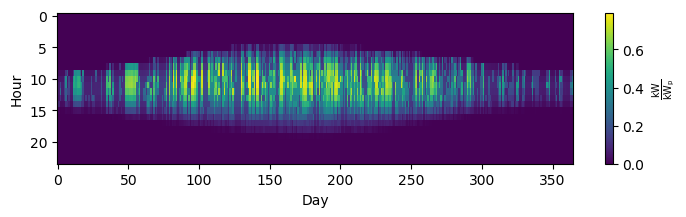

In [5]:
plotTS(raw, 24, vmin = raw['Photovoltaic\r\n[kW/kWp]'].min(), vmax = raw['Photovoltaic\r\n[kW/kWp]'].max(), figName='bla')

In [6]:
len(raw.values)

8760

In [7]:
t0=time.time()
adjacencyMatrix=np.eye(len(raw.values),k=1)+np.eye(len(raw.values),k=-1)
clustering = AgglomerativeClustering(
    n_clusters=1460, linkage='ward', connectivity=adjacencyMatrix)
clusterOrder = clustering.fit_predict(raw.values)
t1=time.time()
print(t1-t0)

2.7299997806549072


In [8]:
clusterCenters, predicted = meanRepresentation(raw.values, clusterOrder)

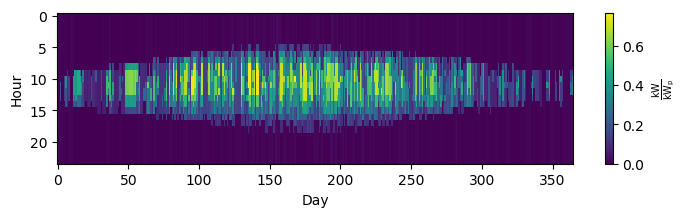

In [9]:
plotTS(raw, 24, vmin = raw['Photovoltaic\r\n[kW/kWp]'].min(), vmax = raw['Photovoltaic\r\n[kW/kWp]'].max(), figName='Segmentation')

In [10]:
test=pd.DataFrame({'vals':raw['Photovoltaic\r\n[kW/kWp]'].values, 'weight':1})

In [11]:
t2=time.time()
for i in range(int(8760-8760/6)):
    mergeIdx=abs(test.diff()).loc[:,'vals'].idxmin()
    test.iloc[mergeIdx,:]+test.iloc[mergeIdx-1,:]
    centroid=(test.iloc[mergeIdx,0]*test.iloc[mergeIdx,1]+test.iloc[mergeIdx-1,0]*test.iloc[mergeIdx-1,1])/(test.iloc[mergeIdx,1]+test.iloc[mergeIdx-1,1])
    newWeight=test.iloc[mergeIdx,1]+test.iloc[mergeIdx-1,1]
    test.iloc[mergeIdx-1,0]=centroid
    test.iloc[mergeIdx-1,1]=newWeight
    test=test.drop(mergeIdx).reset_index(drop=True)
t3=time.time()
print(t3-t2)

21.052000045776367
